## Fit 3D Variogram Functions

The 3D Gaussian variogram function has the following form:

$\gamma = s(1 - e^{-3h^{\top} \Omega h} + 0.06e^{-7.07h^{\top} \Omega h})$

where $\Omega$ is a diagonal matrix with diagonal terms $= [\frac{1}{{r_{lon}}^2}, \frac{1}{{r_{lat}}^2}, \frac{1}{{r_{time}}^2}]$

In [7]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.variogram.VariogramFitting import VariogramFitting
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# read in 2D/3D variogram data
file_path = "/home/jonas/Downloads/tuned_variograms/tuned_variogram_2d_cross_buoy_only.csv"
# file_path = "/home/jonas/Downloads/tuned_variograms/tuned_variogram_2d.csv"
data = pd.read_csv(file_path)
data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,space_lag,t_lag,u_semivariance,v_semivariance
0,10,5,0.166656,0.206893
1,10,10,0.398217,0.378309
2,10,15,0.492462,0.433275
3,10,20,0.502607,0.444698
4,10,25,0.374501,0.354957
...,...,...,...,...
7995,800,480,1.006384,1.027122
7996,800,485,1.045250,1.010631
7997,800,490,1.063253,0.996242
7998,800,495,1.075005,1.021415


In [8]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
# list of optimization algorithms: https://lmfit.github.io/lmfit-py/fitting.html
fitted_v.fit_model(4, method="least_squares", constrain_weighting=True)

Number of models: 4
Type of model: gaussian_2d
Parameters:
 [[3.34777823e-10 1.24421015e+01 1.22868793e+01]
 [4.08061595e-08 1.02129900e+01 1.00255802e+01]
 [3.60201413e-01 2.24333536e+01 1.00000002e+01]
 [6.39798546e-01 1.00509573e+01 5.65914656e+01]]


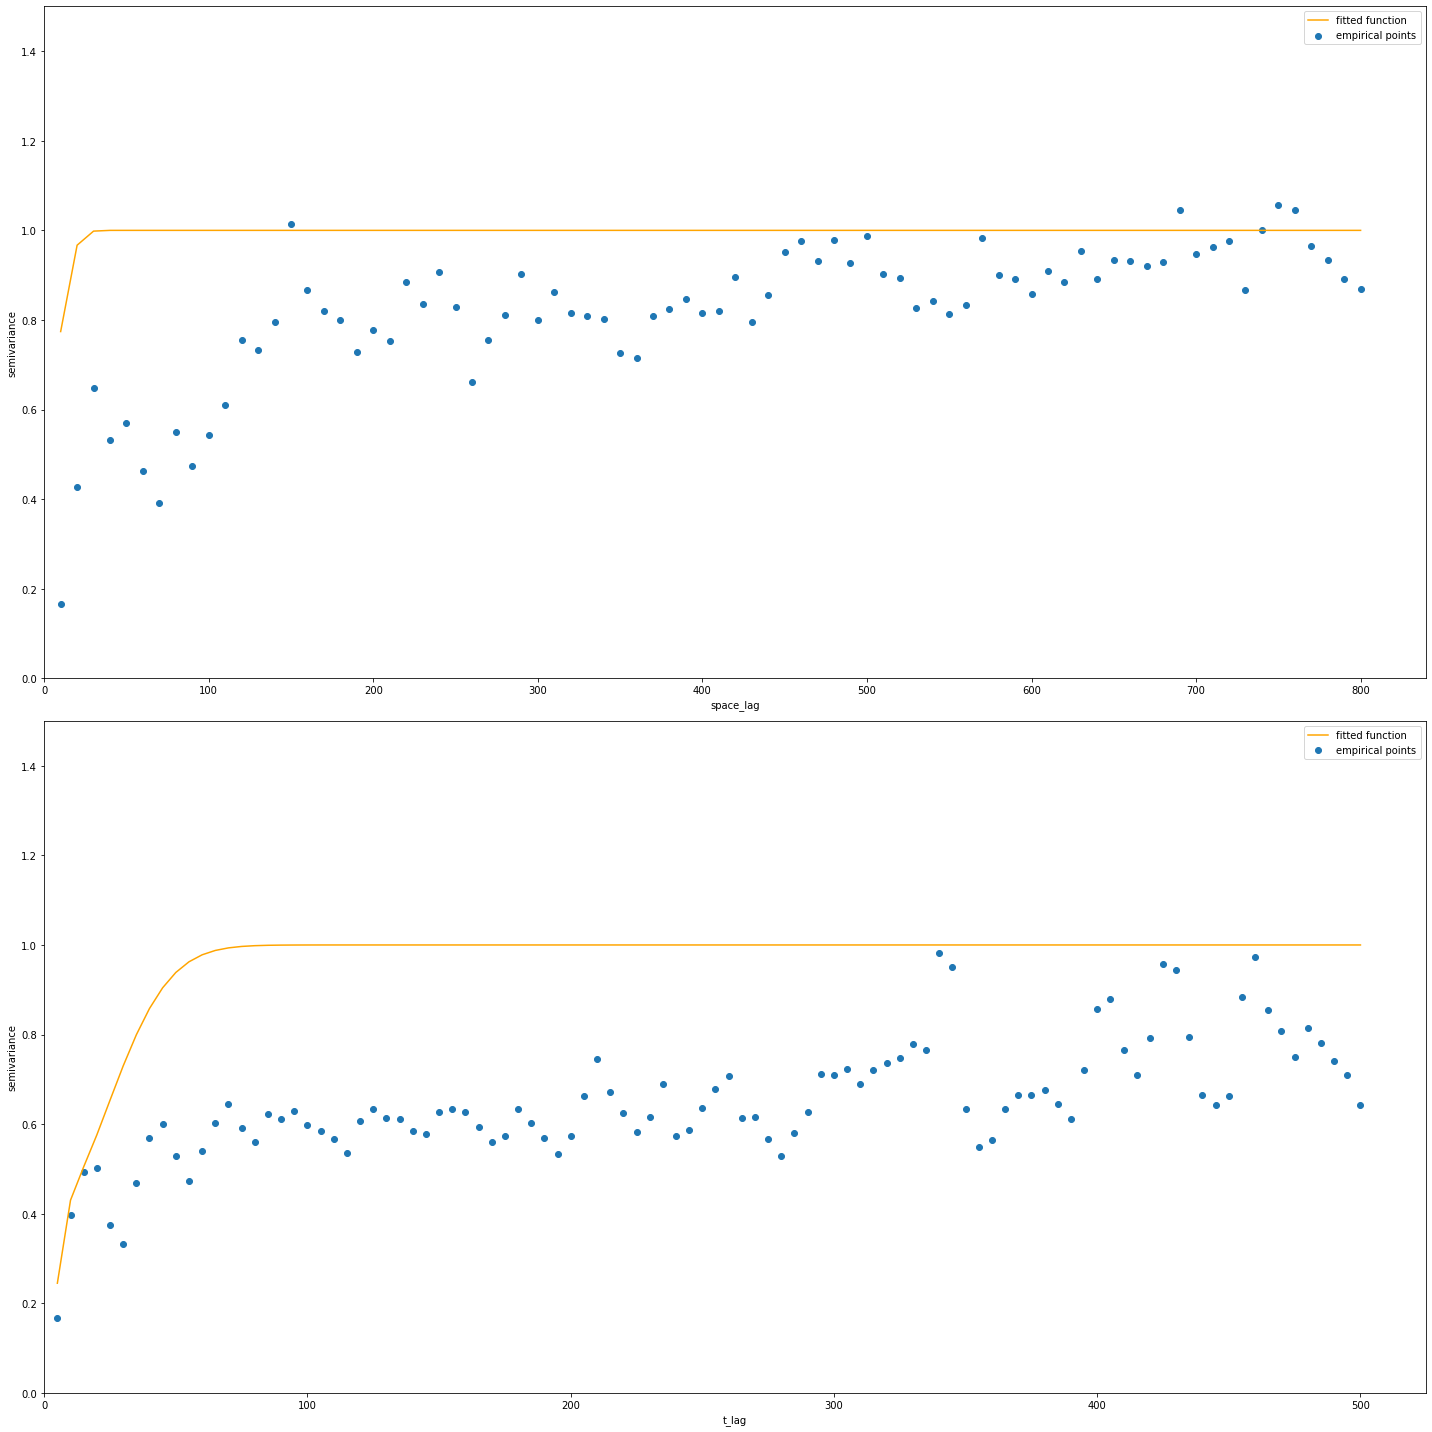

In [9]:
save_path = f"/home/jonas/Downloads/plots/fitted_func_only_cross_buoy.png"
figure = fitted_v.plot_all_dims(save_path=None)

In [5]:
# save parameters
fitted_v.save_params("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_params/test.npy")

## Plot model from parameters

In [ ]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
fitted_v.load_params("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_params/hindcast_area1_True_True.npy")
fitted_v.plot_all_dims()
print(fitted_v.popt)

## Visualize Sampled Error

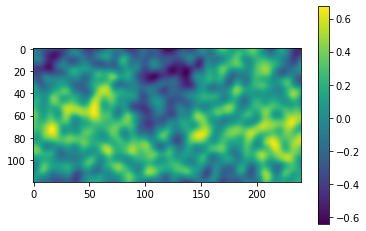

In [3]:
ds = xr.open_dataset("/home/jonas/Downloads/temp/sample_noise.nc")
u_error = ds["u_error"].values[:,:,0]
u_error = u_error.T
plt.imshow(u_error)
plt.colorbar()
plt.show()